<a href="https://colab.research.google.com/github/Selva-Subramanian/Yes-Bank-Stock-Closing-Price-Prediction/blob/main/Yes_Bank_Stock_Closing_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Open in Github](https://github.com/Selva-Subramanian/Yes-Bank-Stock-Closing-Price-Prediction/blob/main/Yes_Bank_Stock_Closing_Price_Prediction.ipynb)**

# **Capstone Project 2 - Yes Bank Stock Closing Price Prediction**

## **(Supervised - Regression)**

## <u>**Project by *Selva Subramanian S*** 

### **Data Science Trainee at AlmaBetter**

# **Problem Statement**

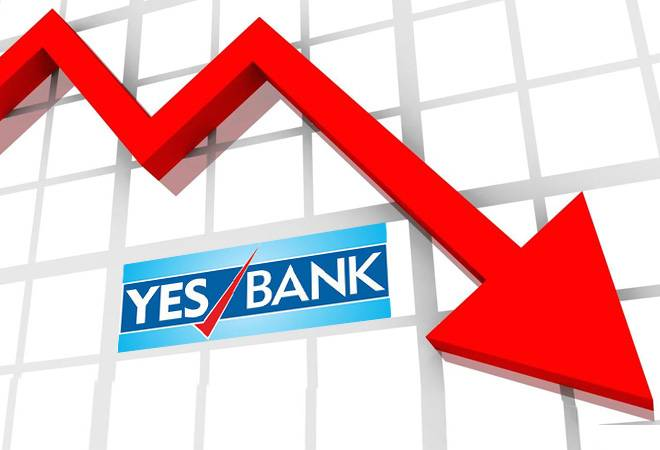

#### Yes Bank is a well-known bank in the Indian financial domain. Since 2018, it has been in the news because of the fraud case involving Rana Kapoor. Owing to this fact, it was interesting to see how that impacted the stock prices of the company and whether Time series models or any other predictive models can do justice to such situations. This dataset has monthly stock prices of the bank since its inception and includes closing, starting, highest, and lowest stock prices of every month. The main objective is to predict the stock’s closing price of the month.

In [2]:
# mount drive to load dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [430]:
# importing the required libraries
import warnings                                        # do not disturb mode
warnings.filterwarnings('ignore')

import numpy as np                                     # numerical computations
import pandas as pd                                    # data manipulations

import matplotlib.pyplot as plt                        # visualize with plots
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import plotly.express as px                       

from datetime import datetime                          # to convert to date
from statsmodels.tsa.arima_model import ARIMA          # to build ARIMA
from fbprophet import Prophet                          # to build prophet

from dateutil.relativedelta import relativedelta       # working with dates with style
from datetime import datetime                          # computational cost
from scipy.optimize import minimize                    # for function minimization
import copy                                            # create copies

from sklearn.preprocessing import (MinMaxScaler,       # scale the data
StandardScaler)         
from sklearn.model_selection import train_test_split   # split train and test data
from sklearn.model_selection import (cross_val_score,  # split train and test data on a timeseries
TimeSeriesSplit)

from sklearn.linear_model import LinearRegression      # regression model
from xgboost import XGBRegressor                       # xgboost model
from sklearn.ensemble import RandomForestRegressor     # random forest model
from sklearn.svm import SVR                            # support vector regressor
from sklearn.linear_model import (Lasso, Ridge,        # regularization
ElasticNet, LassoCV, RidgeCV, ElasticNetCV)
from sklearn.model_selection import GridSearchCV       # grid search to optimize parameters

from sklearn.metrics import (r2_score,                 # import required metrics
mean_squared_error,  mean_absolute_percentage_error, 
mean_absolute_error)

from statsmodels.tsa.stattools import adfuller         # statistics and econometrics
# import statsmodels.formula.api as smf                  
# import statsmodels.tsa.api as smt
# import statsmodels.api as sm
# import scipy.stats as scs

In [431]:
# load the dataset
working_dir_path = "/content/drive/MyDrive/Colab Notebooks/AlmaBetter Notebooks/Capstone projects/Yes Bank Stock Closing Price Prediction - Selva Subramanian S/"
df = pd.read_csv(working_dir_path + "data_YesBank_StockPrices.csv")

In [432]:
# sample of dataset
df.head()

,Date,Open,High,Low,Close
0,Jul-05,13.00,14.00,11.25,12.46
1,Aug-05,12.58,14.88,12.55,13.42
2,Sep-05,13.48,14.87,12.27,13.30
3,Oct-05,13.20,14.47,12.40,12.99
4,Nov-05,13.35,13.88,12.88,13.41


In [433]:
# number of rows and columns in the dataset
df.shape

(185, 5)

In [434]:
# brief summary of the dataset
df.describe()

,Open,High,Low,Close
count,185.000000,185.000000,185.000000,185.000000
mean,105.541405,116.104324,94.947838,105.204703
std,98.879850,106.333497,91.219415,98.583153
min,10.000000,11.240000,5.550000,9.980000
25%,33.800000,36.140000,28.510000,33.450000
50%,62.980000,72.550000,58.000000,62.540000
75%,153.000000,169.190000,138.350000,153.300000
max,369.950000,404.000000,345.500000,367.900000


In [435]:
# details of the features 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    185 non-null    object 
 1   Open    185 non-null    float64
 2   High    185 non-null    float64
 3   Low     185 non-null    float64
 4   Close   185 non-null    float64
dtypes: float64(4), object(1)
memory usage: 7.4+ KB


*  We have a total of 185 entries. <br>
*  No null values. <br>
*  Date column is of 'object' datatype we have to convert it to 'datetime'.


In [436]:
# convert string object to datetime object
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%b-%y"))

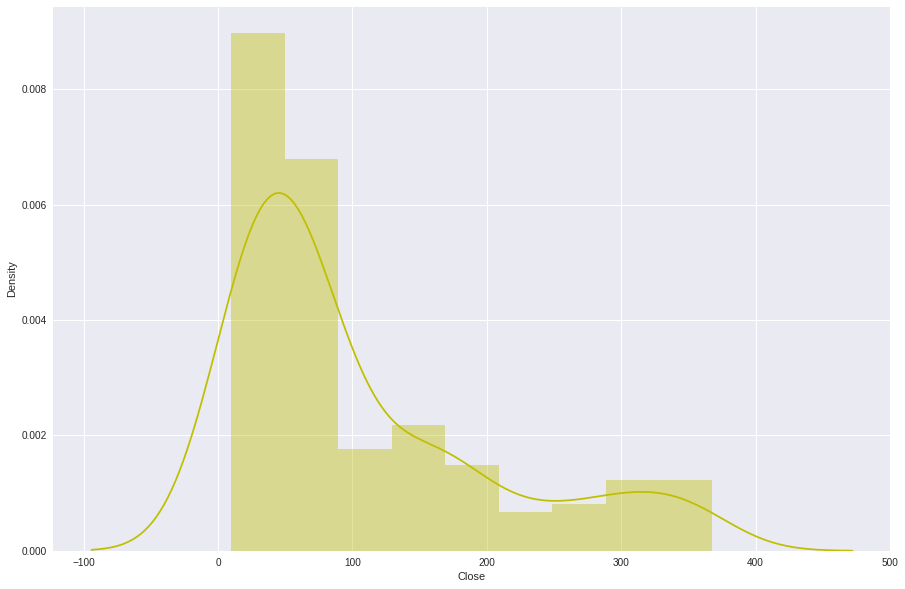

In [437]:
# Dependent variable 'Closing price'
plt.figure(figsize=(15,10))
sns.distplot(df['Close'],color="y")

In [438]:
# visualise the data
fig = px.line(df, df['Date'], df['Close'], title='Monthly closing price')
fig.update_layout(
    xaxis=dict(title='Year'),
    yaxis=dict(title='Closing price'),
    autosize=False,
    width=1400,
    height=400)

fig.show()

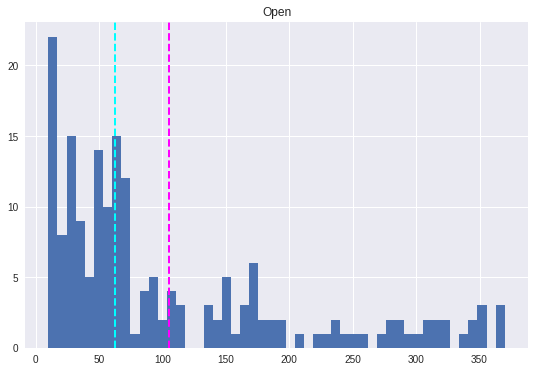

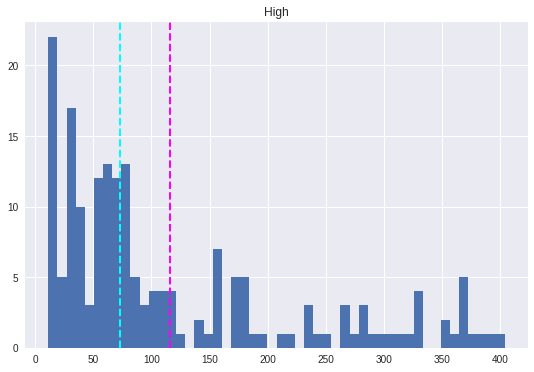

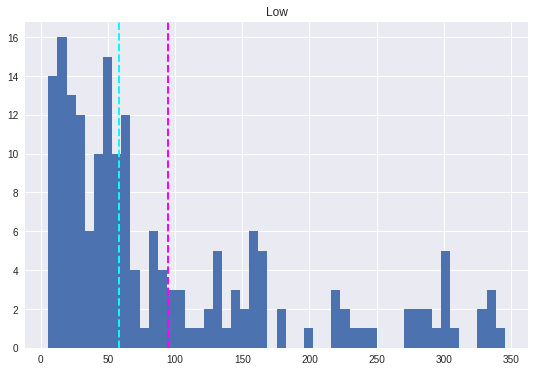

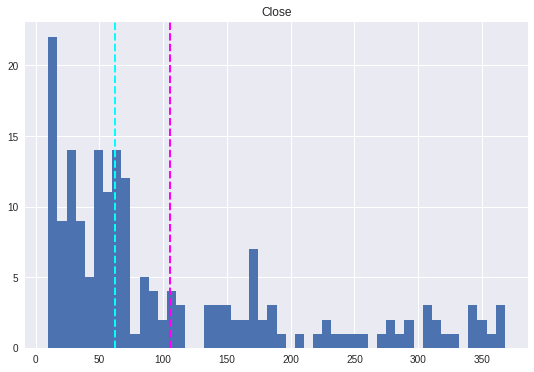

In [439]:
# Check for skewness in the dataset
numeric_features = df.describe().columns
for col in numeric_features[0:4]:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=50, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
    ax.set_title(col)
plt.show()

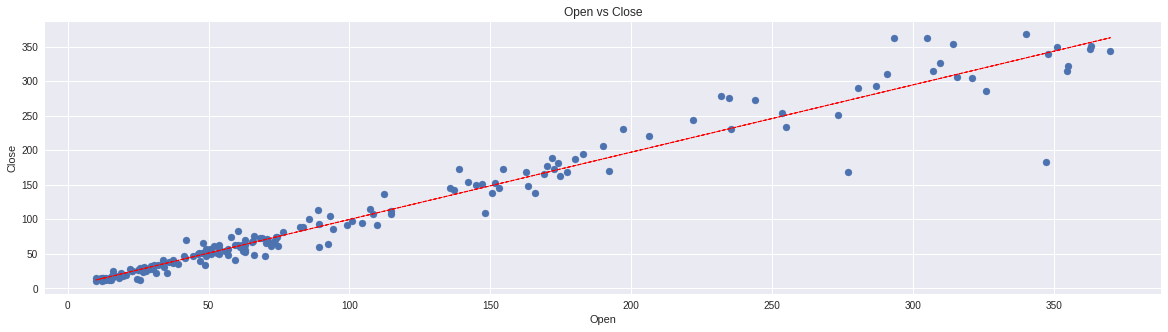

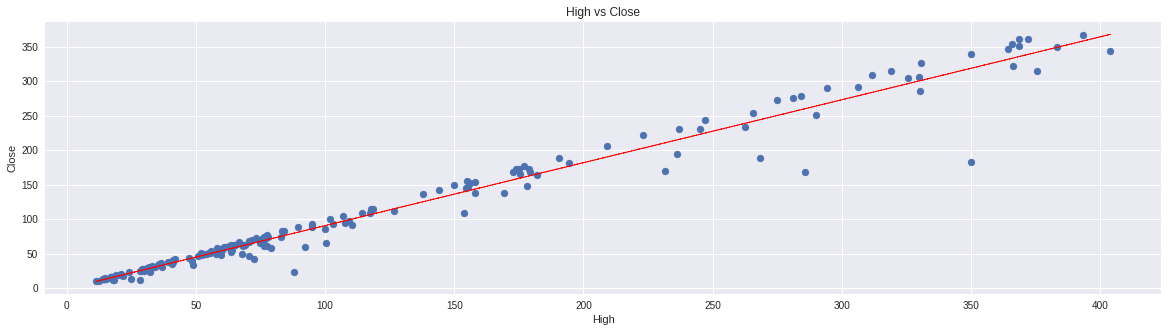

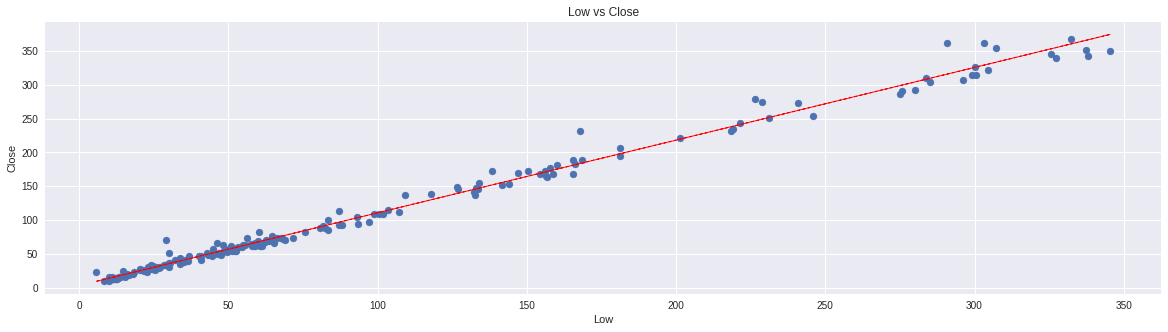

In [440]:
# scatter plot to see the relationship between dependent & independent variables
for col in df.describe().columns[:-1]:
  fig = plt.figure(figsize=(20,5))
  ax = fig.gca()
  plt.scatter(df[col], df['Close'])
  plt.xlabel(col)
  plt.ylabel('Close')
  ax.set_title('{} vs Close'.format(col))
  z = np.polyfit(df[col], df['Close'], 1)
  y_hat = np.poly1d(z)(df[col])
  plt.plot(df[col], y_hat, "r--", lw=1)
  plt.show()

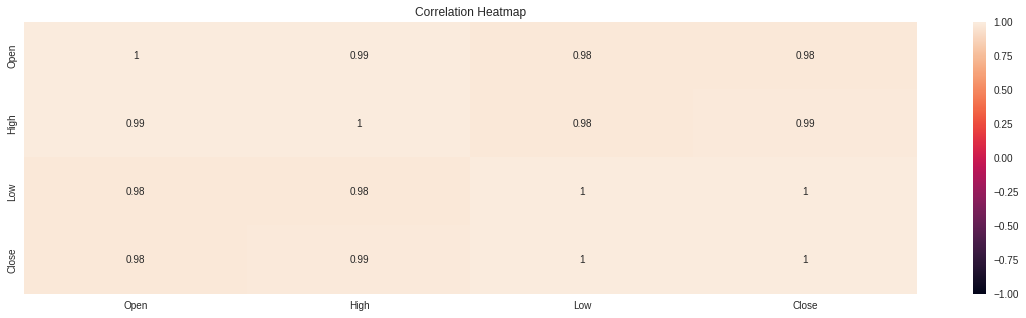

In [441]:
# check for existence of corelation
plt.figure(figsize=(20,5))
plt.title('Correlation Heatmap')
cor = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=None, annot=True )

### Every feature is extremely corelated with each other, so taking just one feature or average of these features would suffice for our regression model as linear regression assumes there is no multi colinearity in the features.

### <b> Feature Engineering

In [442]:
# Creating a new feature based on average of other features in the dataset
df['OHL'] = df[['Open', 'High', 'Low']].mean(axis=1).round(2)
df.head()

,Date,Open,High,Low,Close,OHL
0,2005-07-01,13.00,14.00,11.25,12.46,12.75
1,2005-08-01,12.58,14.88,12.55,13.42,13.34
2,2005-09-01,13.48,14.87,12.27,13.30,13.54
3,2005-10-01,13.20,14.47,12.40,12.99,13.36
4,2005-11-01,13.35,13.88,12.88,13.41,13.37


### Linear regression also assumes a linear relationship between the target variables and independent variables, let's check if such relationship exists through a scatter plot

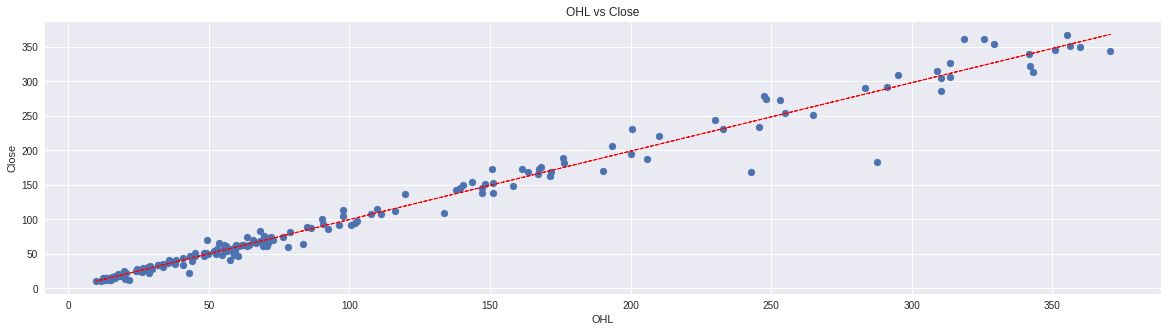

In [443]:
# scatter plot to see the relationship between dependent & independent variables
fig = plt.figure(figsize=(20,5))
ax = fig.gca()
plt.scatter(df['OHL'], df['Close'])
plt.xlabel('OHL')
plt.ylabel('Close')
ax.set_title('OHL vs Close')
z = np.polyfit(df['OHL'], df['Close'], 1)
y_hat = np.poly1d(z)(df['OHL'])
plt.plot(df['OHL'], y_hat, "r--", lw=1)
plt.show()

In [444]:
# use lags as additional features
for i in range(1, 13):
    df["lag_{}".format(i)] = df.OHL.shift(i) 

In [445]:
# sample of the dataset
df.tail()

,Date,Open,High,Low,Close,OHL,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
180,2020-07-01,25.60,28.30,11.10,11.95,21.67,28.42,28.20,24.35,42.90,37.80,43.98,60.40,68.77,49.23,57.67,78.25,100.65
181,2020-08-01,12.00,17.16,11.85,14.37,13.67,21.67,28.42,28.20,24.35,42.90,37.80,43.98,60.40,68.77,49.23,57.67,78.25
182,2020-09-01,14.30,15.34,12.75,13.15,14.13,13.67,21.67,28.42,28.20,24.35,42.90,37.80,43.98,60.40,68.77,49.23,57.67
183,2020-10-01,13.30,14.01,12.11,12.42,13.14,14.13,13.67,21.67,28.42,28.20,24.35,42.90,37.80,43.98,60.40,68.77,49.23
184,2020-11-01,12.41,14.90,12.21,14.67,13.17,13.14,14.13,13.67,21.67,28.42,28.20,24.35,42.90,37.80,43.98,60.40,68.77


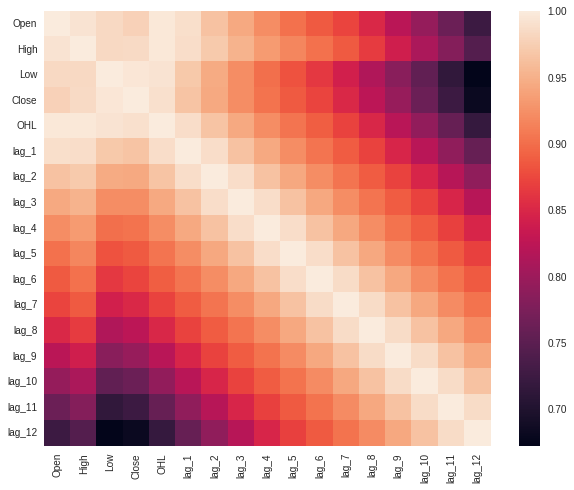

In [446]:
# correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr())

#### To reduce multicollinearity we can use regularization that means to keep all the features but reducing the magnitude of the coefficients of the model. This is a good solution when each predictor contributes to predict the dependent variable.

### <b> Train-Test Split

In [447]:
# 5 fold time-series cross-validation 
tscv = TimeSeriesSplit(n_splits=5)

In [448]:
# function for splitting time-series dataset
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    scaler = StandardScaler()
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [449]:
# choose appropriate dependent and independent variables
y = df.dropna().Close
X = df.dropna().drop(['Date','Close','Open','High','Low'], axis=1)

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.2)

# <b> Model Building

### <b> Implementing linear regression model

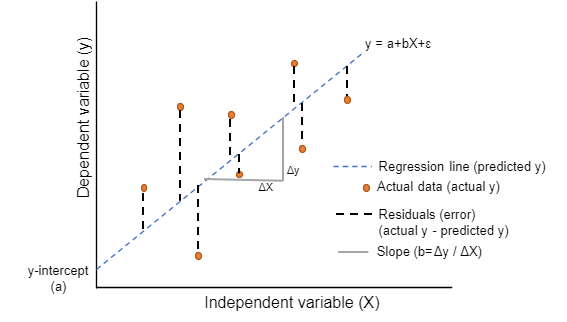

In [450]:
# initialize and fit linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

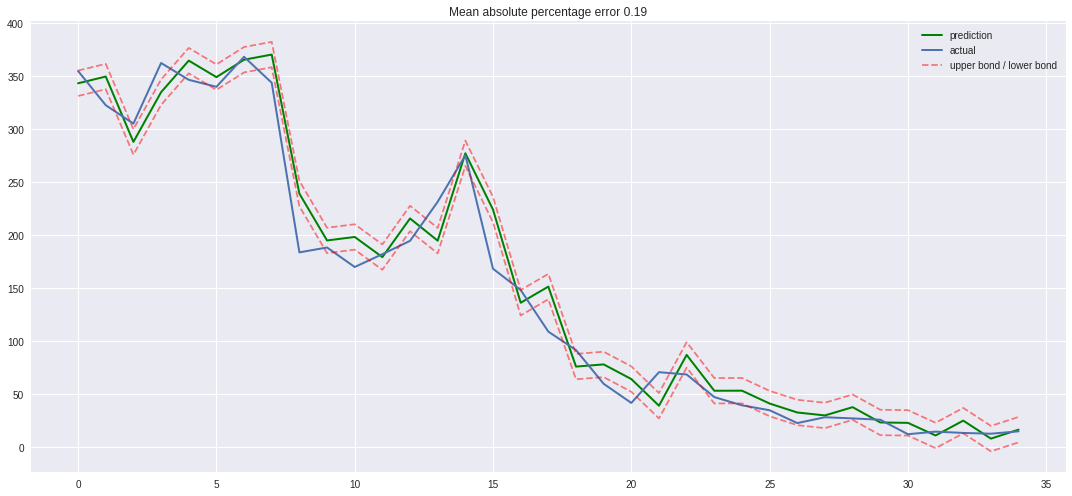

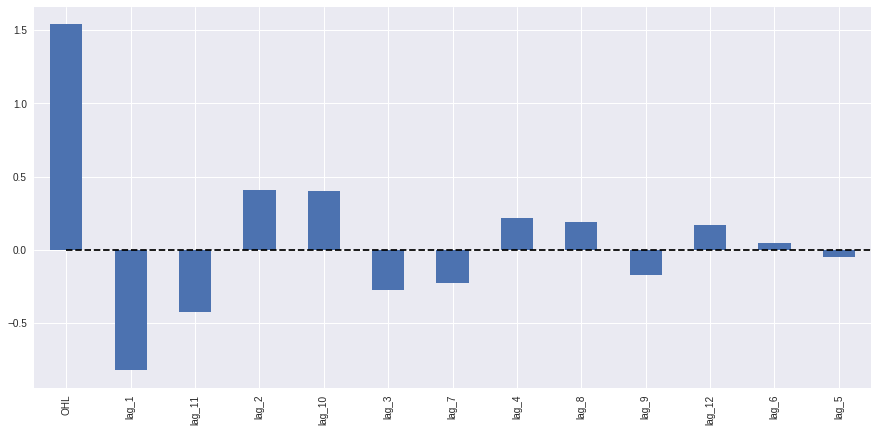

In [451]:
# function to plot model performance
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

# function to plot coefficients   
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

mean absolute error: 16.93

mean squared error: 486.35

root mean squared error: 22.05

r2_score: 0.97

mean absolute percentage error: 0.19





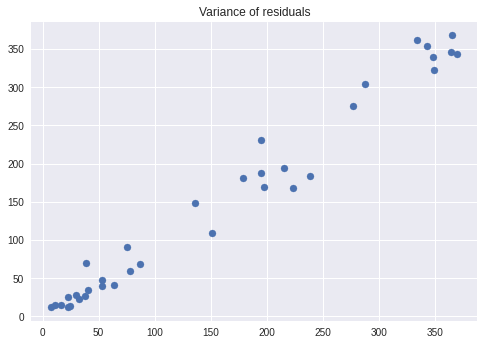

In [452]:
# make predictions
lr_y_pred = lr.predict(X_test)

# evaluate predictions
lr_mae = round(mean_absolute_error(y_test, lr_y_pred),2)
print('mean absolute error: {}\n'.format(lr_mae))
lr_mse = round(mean_squared_error(y_test, lr_y_pred),2)
print('mean squared error: {}\n'.format(lr_mse))
lr_rmse = round(np.sqrt(lr_mse),2)
print('root mean squared error: {}\n'.format(lr_rmse))
lr_r2 = round(r2_score(y_test, lr_y_pred),2)
print('r2_score: {}\n'.format(lr_r2))
lr_mape = round(mean_absolute_percentage_error(lr_y_pred, y_test),2)
print('mean absolute percentage error: {}\n\n\n'.format(lr_mape))

# Check for homoscadacity
plt.scatter(lr_y_pred, y_test)
plt.title('Variance of residuals')
plt.show()

### <b> Implementing ridge regression

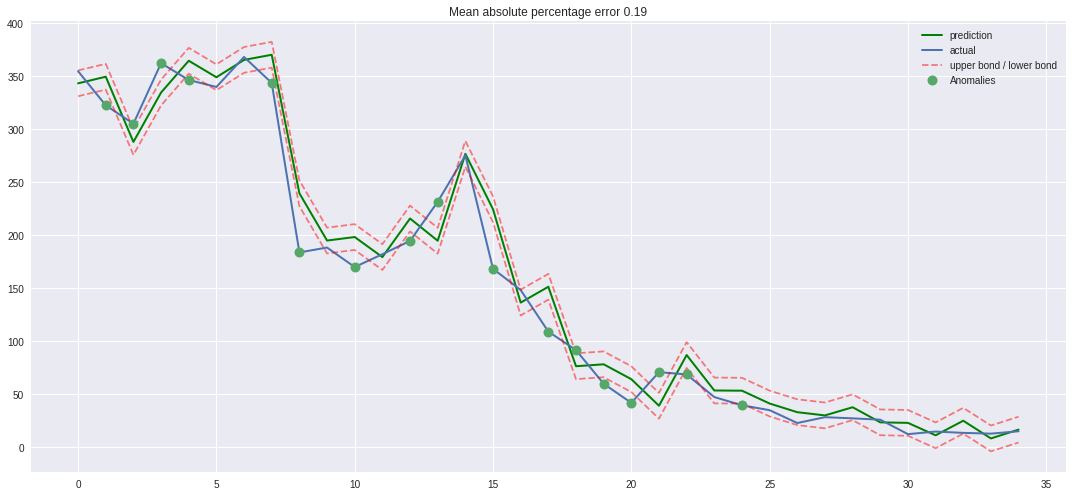

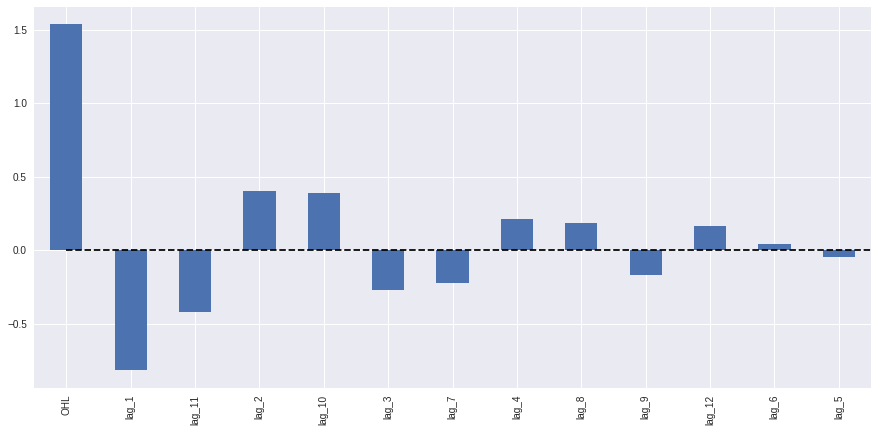

In [453]:
# initialize and fit ridge regression
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

mean absolute error: 16.91

mean squared error: 488.09

root mean squared error: 22.09

r2_score: 0.97

mean absolute percentage error: 0.19





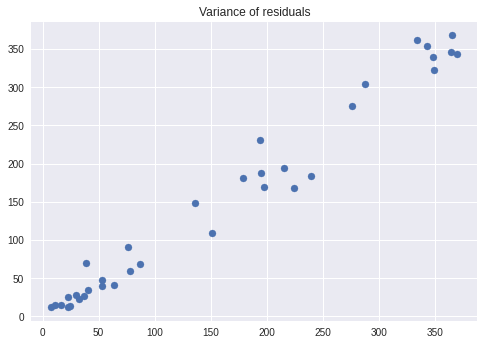

In [454]:
# make predictions
r_y_pred = ridge.predict(X_test)

# evaluate predictions
r_mae = round(mean_absolute_error(r_y_pred, y_test),2)
print('mean absolute error: {}\n'.format(r_mae))
r_mse = round(mean_squared_error(r_y_pred, y_test),2)
print('mean squared error: {}\n'.format(r_mse))
r_rmse = round(np.sqrt(r_mse),2)
print('root mean squared error: {}\n'.format(r_rmse))
r_r2 = round(r2_score(r_y_pred, y_test),2)
print('r2_score: {}\n'.format(r_r2))
r_mape = round(mean_absolute_percentage_error(r_y_pred, y_test),2)
print('mean absolute percentage error: {}\n\n\n'.format(r_mape))

# Check for homoscadacity
plt.scatter(r_y_pred, y_test)
plt.title('Variance of residuals')
plt.show()

### <b> Implementing lasso regression

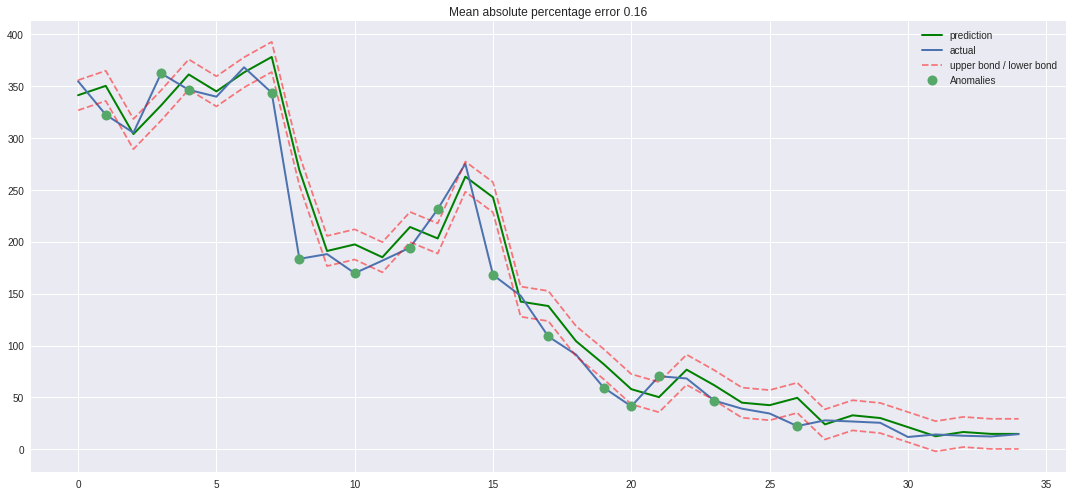

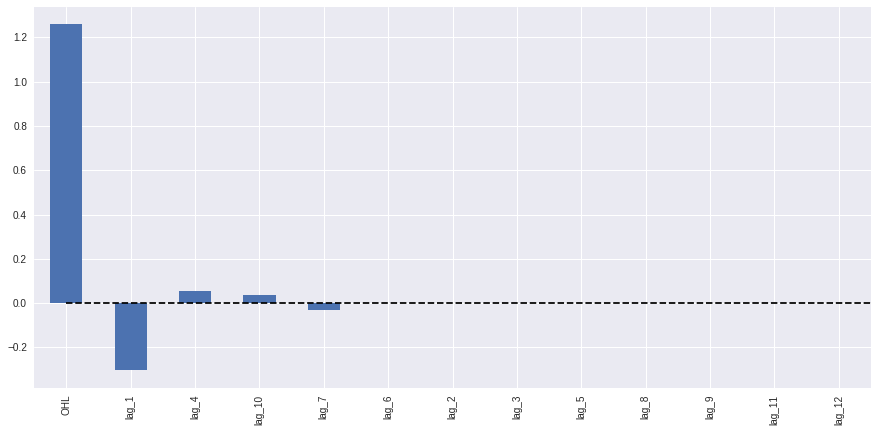

In [455]:
# initialize and fit lasso regression
lasso = LassoCV(cv=tscv)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

mean absolute error: 16.87

mean squared error: 626.48

root mean squared error: 25.03

r2_score: 0.96

mean absolute percentage error: 0.16





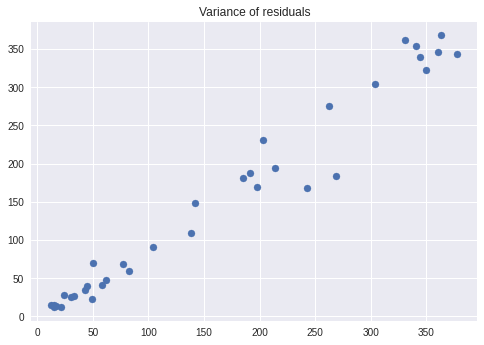

In [456]:
# make predictions
l_y_pred = lasso.predict(X_test)

# evaluate predictions
l_mae = round(mean_absolute_error(y_test, l_y_pred),2)
print('mean absolute error: {}\n'.format(l_mae))
l_mse = round(mean_squared_error(y_test, l_y_pred),2)
print('mean squared error: {}\n'.format(l_mse))
l_rmse = round(np.sqrt(l_mse),2)
print('root mean squared error: {}\n'.format(l_rmse))
l_r2 = round(r2_score(y_test, l_y_pred),2)
print('r2_score: {}\n'.format(l_r2))
l_mape = round(mean_absolute_percentage_error(l_y_pred, y_test),2)
print('mean absolute percentage error: {}\n\n\n'.format(l_mape))

# Check for homoscadacity
plt.scatter(l_y_pred, y_test)
plt.title('Variance of residuals')
plt.show()

### <b> Implementing elasticnet regression

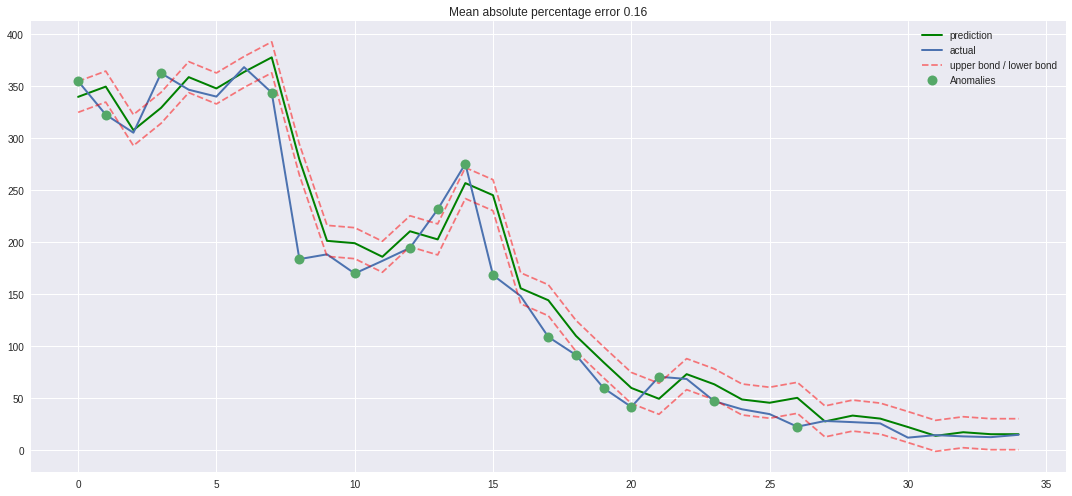

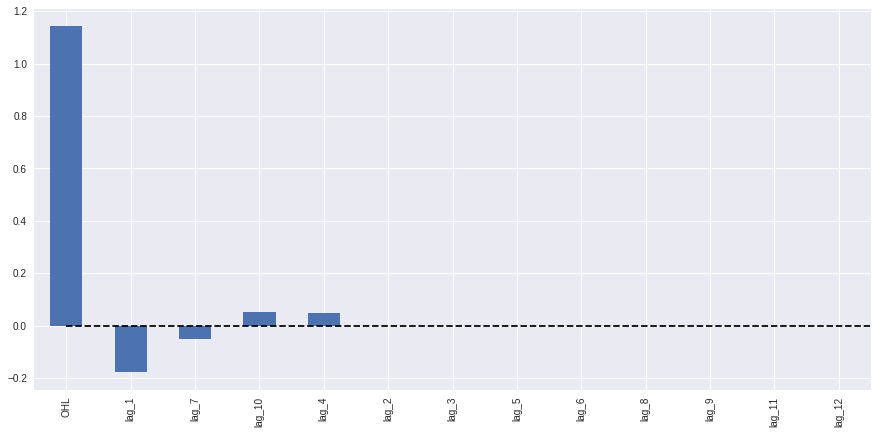

In [457]:
# initialize and fit elasticnet regression
elasticnet = ElasticNetCV(cv=tscv)
elasticnet.fit(X_train, y_train)

plotModelResults(elasticnet, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(elasticnet)

mean absolute error: 18.34

mean squared error: 726.63

root mean squared error: 26.96

r2_score: 0.95

mean absolute percentage error: 0.16





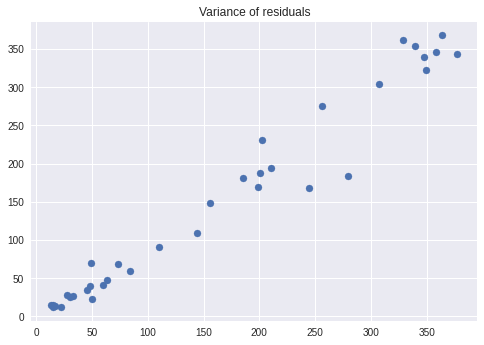

In [458]:
# make predictions
e_y_pred = elasticnet.predict(X_test)

# evaluate predictions
e_mae = round(mean_absolute_error(y_test, e_y_pred),2)
print('mean absolute error: {}\n'.format(e_mae))
e_mse = round(mean_squared_error(y_test, e_y_pred),2)
print('mean squared error: {}\n'.format(e_mse))
e_rmse = round(np.sqrt(e_mse),2)
print('root mean squared error: {}\n'.format(e_rmse))
e_r2 = round(r2_score(y_test, e_y_pred),2)
print('r2_score: {}\n'.format(e_r2))
e_mape = round(mean_absolute_percentage_error(e_y_pred, y_test),2)
print('mean absolute percentage error: {}\n\n\n'.format(e_mape))

# Check for homoscadacity
plt.scatter(e_y_pred, y_test)
plt.title('Variance of residuals')
plt.show()

### <b> Evaluation Summary

In [459]:
# create dataframe with evaluation metrics
model_report = pd.DataFrame(data={'model':['linear regression','ridge regression','lasso regression','elastic net regression'], 'mae':[lr_mae,r_mae,l_mae,e_mae], 'mse':[lr_mse,r_mse,l_mse,e_mse],'rmse':[lr_rmse,r_rmse,l_rmse,e_rmse],'r2_score':[lr_r2,r_r2,l_r2,e_r2],'mape':[lr_mape,r_mape,l_mape,e_mape]})
model_report 

,model,mae,mse,rmse,r2_score,mape
0,linear regression,16.93,486.35,22.05,0.97,0.19
1,ridge regression,16.91,488.09,22.09,0.97,0.19
2,lasso regression,16.87,626.48,25.03,0.96,0.16
3,elastic net regression,18.34,726.63,26.96,0.95,0.16


### <b> Model pipeline

In [460]:
# set up the model pipeline
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

### <b> Implementing Random Forest Regressor

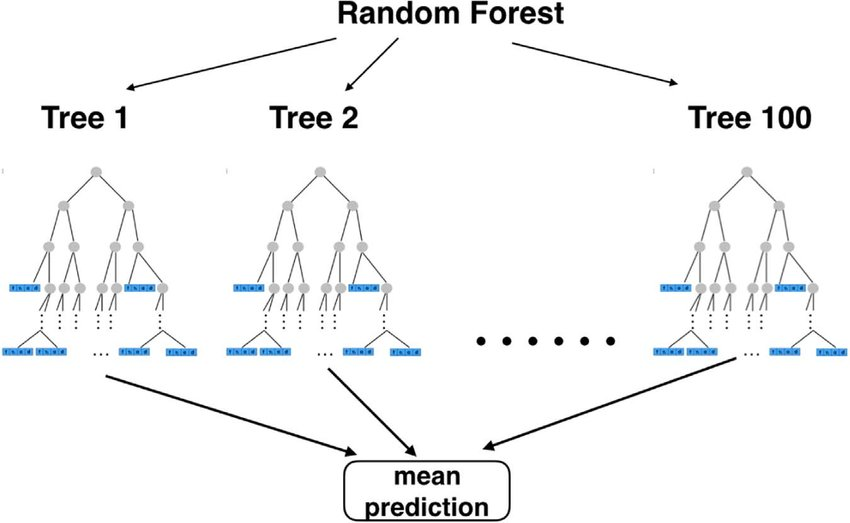

In [461]:
# initialize and fit random forests regressor
model = RandomForestRegressor()
param_grid = {
    'n_estimators': [100,150,200],
     'max_depth': [20,30,50,100]
}
start = datetime.now()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=tscv)
end = datetime.now()
execution_time = round((end - start).seconds/60,2)
print(f'The computational cost for finding the best fit random forest regressor model: {execution_time} minutes\n')
# Root Mean Squared Error
print(f'Best score: {np.sqrt(-model.best_score_)}\n')
print(f'Best parameters: {model.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The computational cost for finding the best fit random forest regressor model: 0.17 minutes

Best score: 58.51161378776086

Best parameters: {'max_depth': 20, 'n_estimators': 100}


In [462]:
# best fit model
rfr = model.best_estimator_

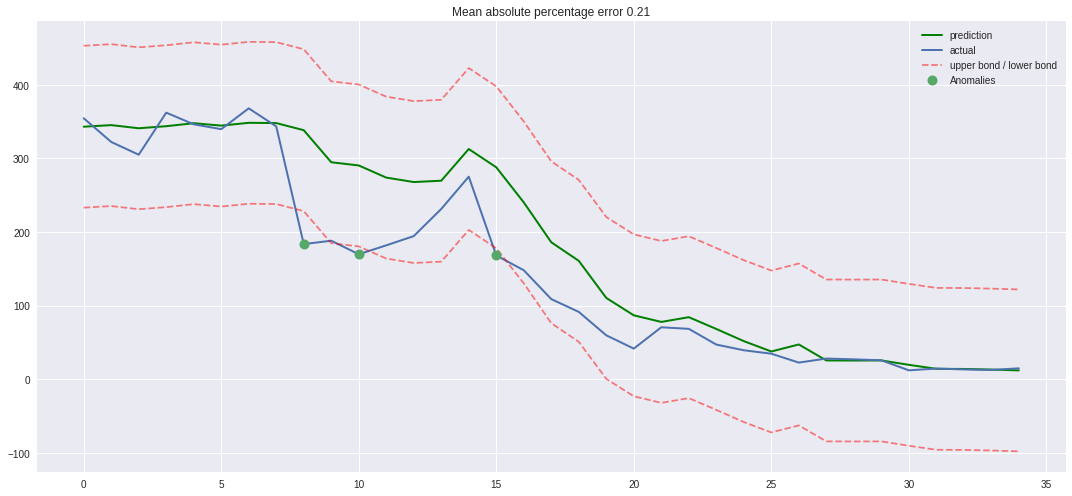

In [463]:
# evaluate the model
plotModelResults(rfr, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)

### <b> Implementing XGBoost Regressor

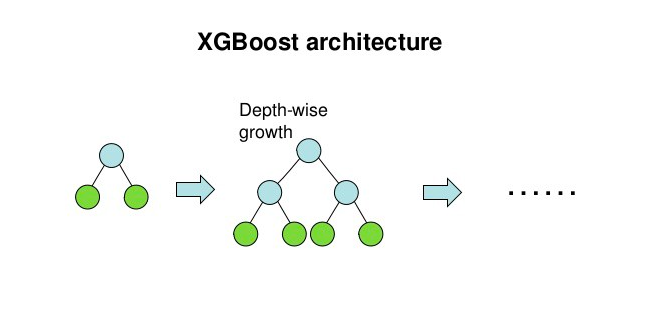

In [464]:
# initialize and fit xgboost regressor
model = XGBRegressor()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
}
start = datetime.now()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=tscv)
end = datetime.now()
execution_time = round((end - start).seconds/60,2)
print(f'The computational cost for finding the best fit XGBoost regressor model: {execution_time} minutes\n')
# Root Mean Squared Error
print(f'Best score: {np.sqrt(-model.best_score_)}\n')
print(f'Best parameters: {model.best_params_}')

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[13:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The computational cost for finding the best fit XGBoost regressor model: 2.32 minutes

Best score: 66.07007559384817

Best parameters: {'colsample_bytree': 0.8, 'max_depth': 15, 'n_estimators': 400, 'reg_alpha': 1.1, 'reg_lambda': 1.1, 'subsample': 0.8}


In [465]:
# best fit model
xgb = model.best_estimator_

[13:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:56:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


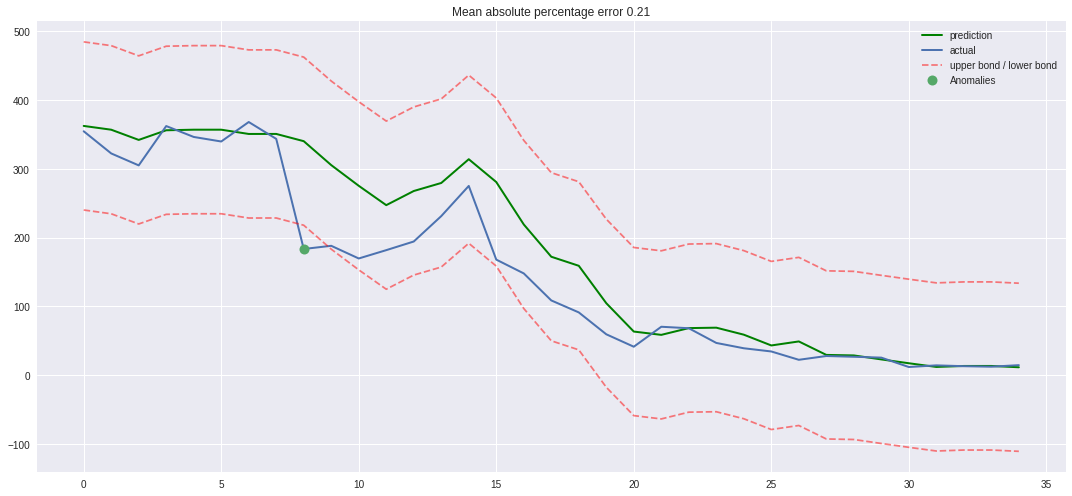

In [466]:
# evaluate the model
plotModelResults(xgb, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)

### <b> Implementing Support Vector Regressor

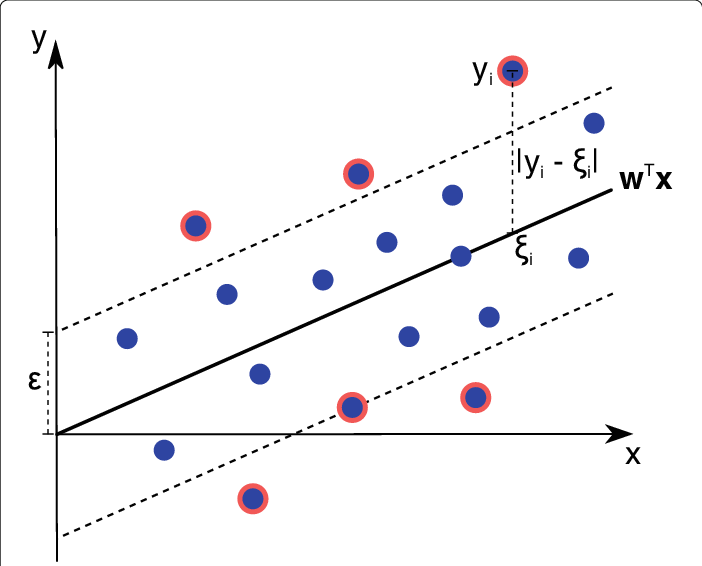

In [467]:
# initialize and fit support vector regressor
model = SVR()
param_grid = {
    'C': [0.1, 1, 10, 100],   
    'kernel': ['rbf']
}
start = datetime.now()
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=tscv)
end = datetime.now()
execution_time = round((end - start).seconds/60,2)
print(f'The computational cost for finding the best fit SVR model: {execution_time} minutes\n')
# Root Mean Squared Error
print(f'Best score: {np.sqrt(-model.best_score_)}\n')
print(f'Best parameters: {model.best_params_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The computational cost for finding the best fit SVR model: 0.0 minutes

Best score: 89.24735610091432

Best parameters: {'C': 10, 'kernel': 'rbf'}


In [468]:
# best fit model
svr = model.best_estimator_

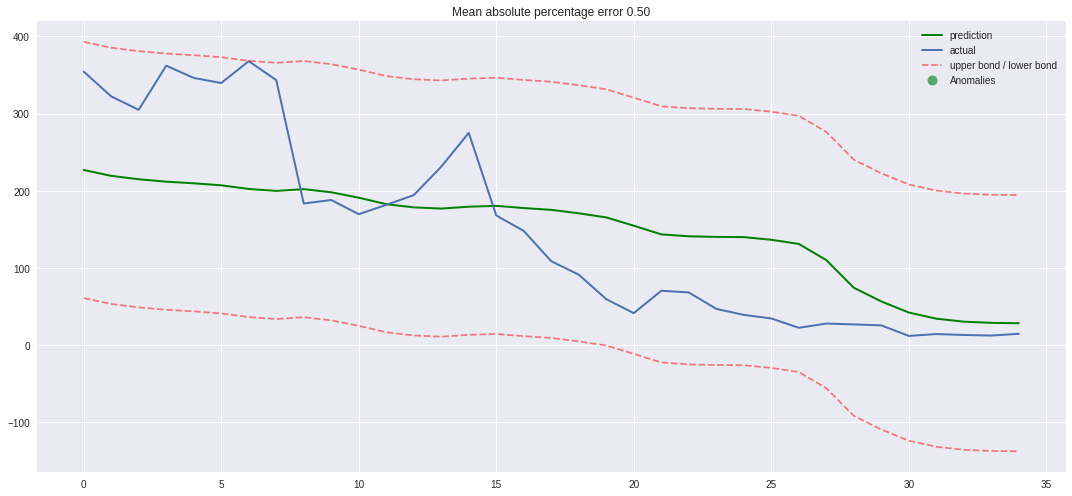

In [469]:
# evaluate the model
plotModelResults(svr, 
                 X_train, 
                 X_test, 
                 plot_intervals=True, plot_anomalies=True)

#### Eventhough it looks like the models are performing very well, there is lot of shortcomings to these models. Remember we have the monthly low and high values of the stock, the closing price will always be within that range so the model may achieve great accuracies but in real time we won't have the open, high, low values readily available beforehand to make predictions for closing price, also we haven't brought the time component into it so far.

## <u>**Time Series Analysis**

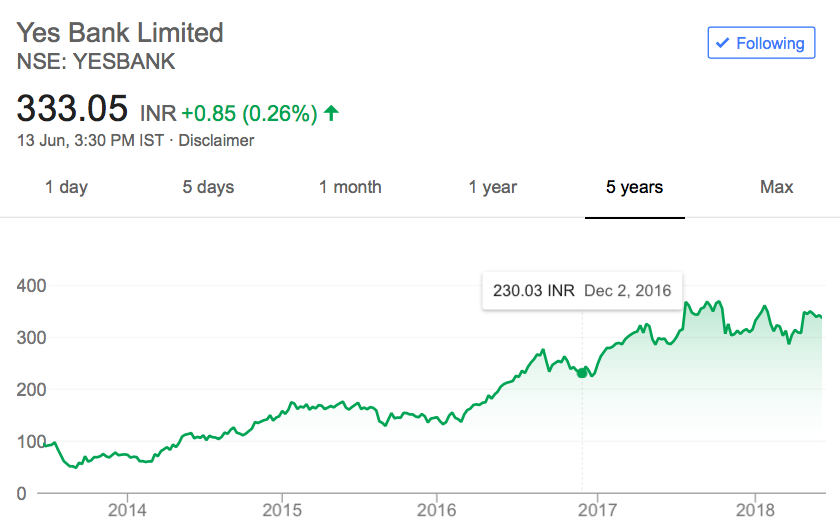

### **Moving Average**

### A moving average much better than a naive forecast ($\hat{y}_t = y_{t-1}$). A **moving average** is the average of previous $k$ values. <br>  $\hat{y}_t = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [470]:
# function for calculating moving average

def moving_average(series, n):
  
  """
  Calculate average of last n observation
  """
  
  return round(np.average(series[-n:]),2)

moving_average(df['Close'],12) # prediction for next month closing price using observed previous 12 months data

24.18

### Unfortunately we can make only one prediction, to make further predictions we need to have the actual observed values. However moving average can be used to identify the trends by smoothing the time series using a pandas implementation [`DataFrame.rolling(window).mean()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html).

In [471]:
# # set back up the date column
# df = df.reset_index()
# df['Date'] = df_date

# function for plotting moving average
def ma(series, window, plot_intervals=False):

  """
  series - dataframe column with timeseries
  window - rolling window size
  """

  rolling_mean = series.rolling(window=window).mean()

  plt.figure(figsize=(20,5))
  plt.title('Moving average \n window size = {}'.format(window))
  plt.plot(df['Date'], rolling_mean, "g", label = "Rolling mean trend")
  
  # plotting confidence intervals
  if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window] - rolling_mean[window:])
    lower_bound = rolling_mean - (mae + deviation)
    upper_bound = rolling_mean + (mae + deviation)
    plt.plot(df['Date'], lower_bound, "r--", label = "Upper/Lower bounds")
    plt.plot(df['Date'], upper_bound, "r--")
  
  plt.plot(df['Date'], series, label = "Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)
  plt.show()

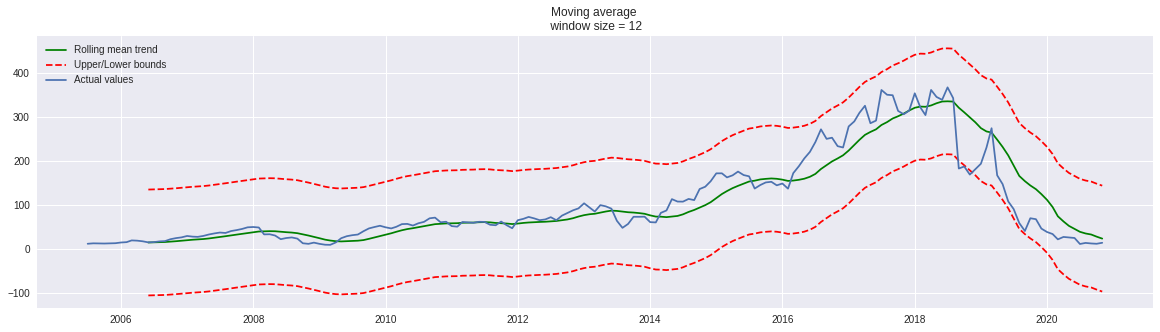

In [472]:
# plotting 12 months moving average 
ma(df['Close'],12, plot_intervals=True) # smoothing by previous 12 months

In [473]:
# function that returns weighted moving average
def wma(series, weights):
  """
  calculate weighted moving average of the series
  """
  result = 0.0
  for w in range(len(weights)):
    result += series.iloc[-w-1] * weights[w]
    return float(result)

wma(df['Close'], weights = [0.5, 0.3, 0.2])

7.335

### Now let's extend this concept of weighted averages to exponentially weighted moving averages

### **Exponentially weighted moving averages** weights all the available observations while exponentially decreasing the weights as we move back $k$ values 

## $$\hat{y}_{t+1} = \alpha \cdot y_t + \alpha(1-\alpha) \cdot y_{t-1} + \alpha(1-\alpha)^2 \cdot y_{t-2} + \alpha(1-\alpha)^3 \cdot y_{t-3} + .... $$

## $$ \hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat{y}_t $$

In [474]:
# function that does exponential smoothing
def exponential_smoothing(series, alpha):
  """
  series - dataframe column with timeseries
  alpha - smoothing parameter
  """
  result = [series[0]]
  for n in range(len(series)):
    result.append(alpha * series[n] + (1 - alpha) * result[n-1])
  return result

In [475]:
# function to plot exponentail moving averages
def ema(series, alphas):
  """
  series - dataframe colummn with time series
  alpha - smoothing parameters
  """
  with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20,5))
    for alpha in alphas:
      plt.plot(exponential_smoothing(series, alpha), label = "Alpha{}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.legend(loc="best")
    plt.grid(True)


In [476]:
# make prediction
round(exponential_smoothing(df['Close'], alpha=0.2)[-1],2)

53.87

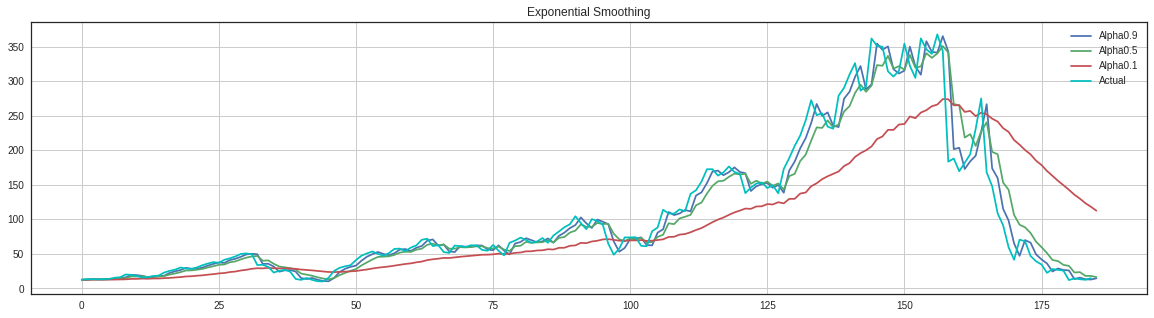

In [477]:
# plot ema
ema(df['Close'], [0.9, 0.5, 0.1])

## <b> Holt's linear trend method (Double exponential smoothing)

### So far we were able to make just one prediction, clearly which is isn't enough. Double exponential smoothing (Holt's linear trend method) is one such way to overcome this limitation. It has two components, intercept $l$ and slope $b$
## $$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$
## $$\ b_x = \beta (\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1} $$
## $$\hat{y}_{x+1} = \ell_x + \ b_x  $$

### The final prediction is the sum of the model values of the intercept and trend.


In [478]:
# function that does double exponential smoothing
def double_exponential_smoothing(series, horizon, alpha, beta):
  """
  series - dataframe column with timeseries
  alpha - smoothing parameter for level
  beta - smoothing parameter for trend
  """
  # first value is same as series
  result = [series[0]]
  for n in range(1, len(series)+horizon):
      if n == 1:
          level, trend = series[0], series[1] - series[0]
      if n >= len(series): 
          value = result[-1]
      else:
          value = series[n]
      last_level, level = level, alpha*value + (1-alpha)*(level+trend)
      trend = beta*(level-last_level) + (1-beta)*trend
      result.append((level+trend).round(2))
  print(result[-horizon:])
  return result

In [479]:
# function to plot dema
def dema(series, horizon, alpha, beta):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataframe column with timeseries
        alphas - smoothing parameters for level
        betas - smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 5))
        plt.plot(double_exponential_smoothing(series, horizon, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

### Predictions by various combinations of alphas and betas

[28.47, 29.2, 29.93, 30.66, 31.39, 32.12]
[23.76, 22.37, 20.98, 19.59, 18.2, 16.81]
[14.17, 8.22, 2.27, -3.68, -9.63, -15.58]
[18.8, 18.44, 18.08, 17.72, 17.36, 17.0]
[34.31, 41.52, 48.73, 55.95, 63.16, 70.37]


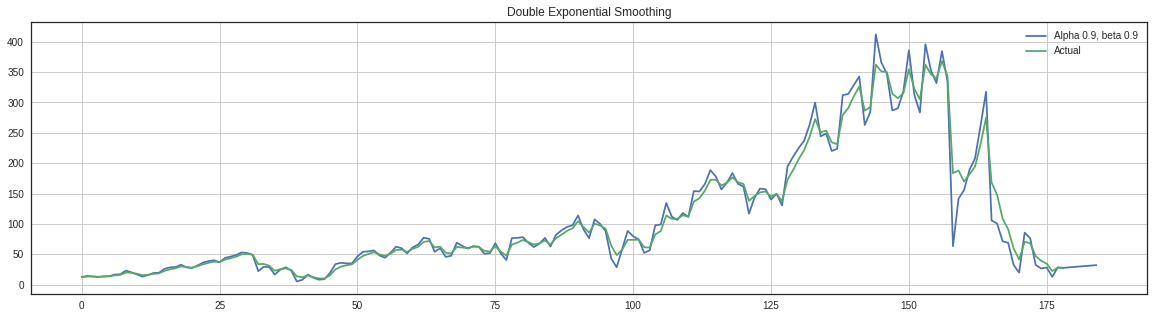

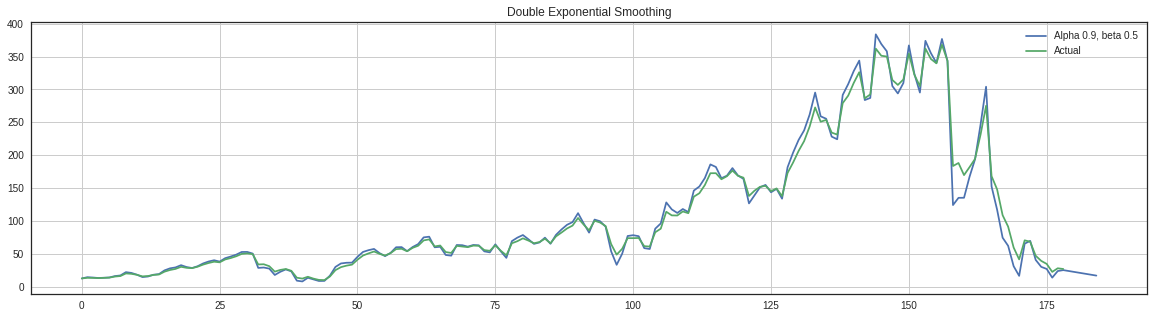

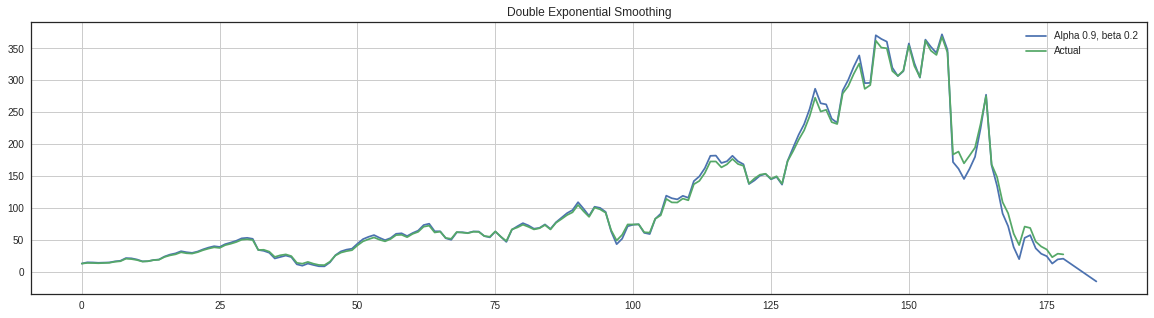

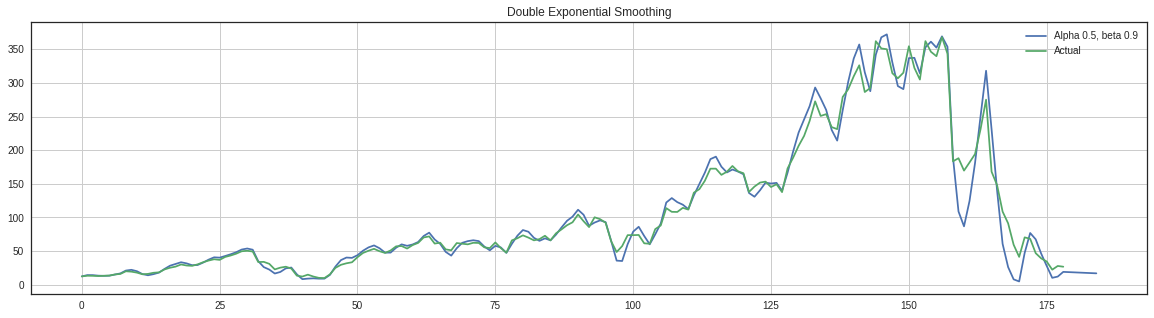

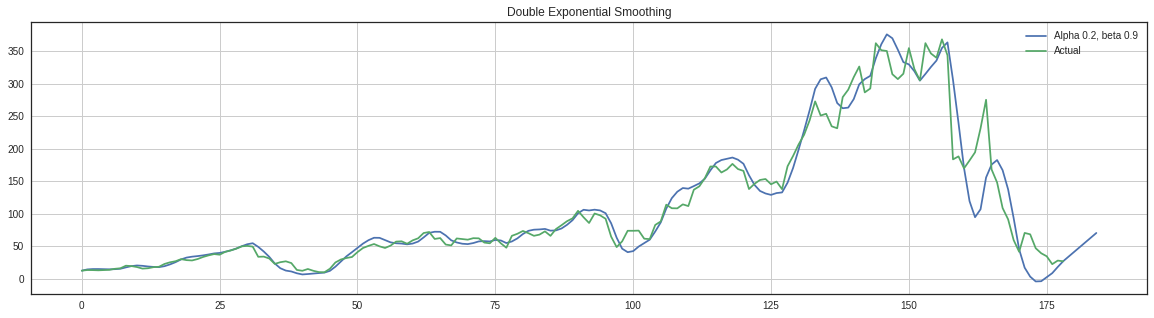

In [480]:
# Try multiple values of alpha and beta
combinations = [(0.9,0.9), (0.9, 0.5), (0.9, 0.2), (0.5, 0.9), (0.2, 0.9)]
for alpha, beta in combinations:
  dema(df['Close'][0:179], 6, alpha, beta)

## <b> Stationarity

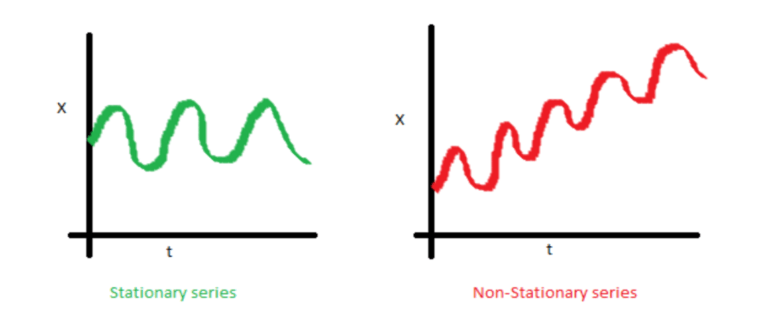

### Any time series need to be stationary to make predictions. A process is said to be stationary if it's statistical properties like mean and variance don't change over time. One way to check for stationarity is through visual inspections or one can conduct a [Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test). The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.


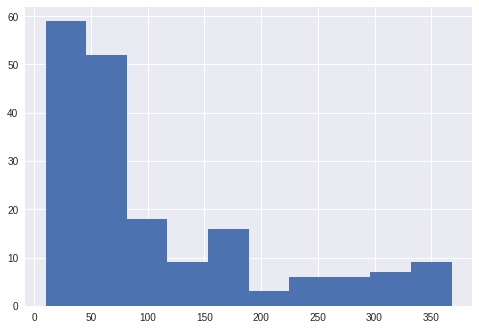

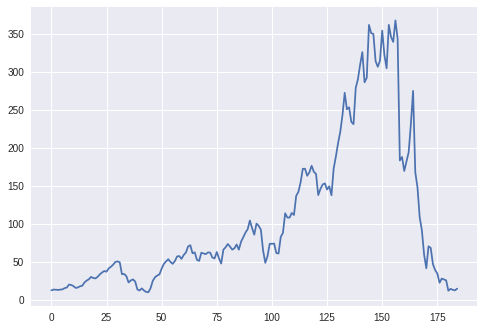

In [481]:
# visual inspection
X = df['Close']
plt.hist(X)
plt.show()
plt.plot(X)
plt.show()

In [482]:
# Implement Dickey-Fuller test
X = df['Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.906409
p-value: 0.329052
Critical Values:
	1%: -3.469
	5%: -2.879
	10%: -2.576


### ADF statistic is greater than all our critical values, thus we have failed to reject the null hypothesis. It's confirmed that our time series model is not stationary. We'll make it stationary to build ARIMA model and then make future predictions.

## <b> ARIMA Implementation

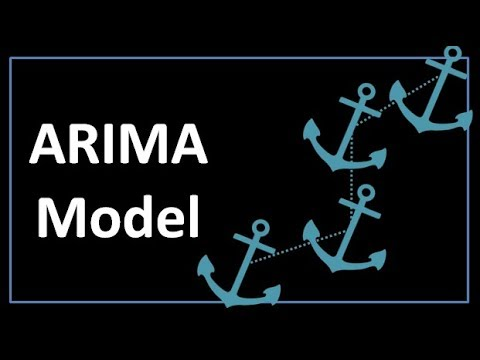

#### <b><u> Getting rid of non stationarity

In [483]:
# function to take lags
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

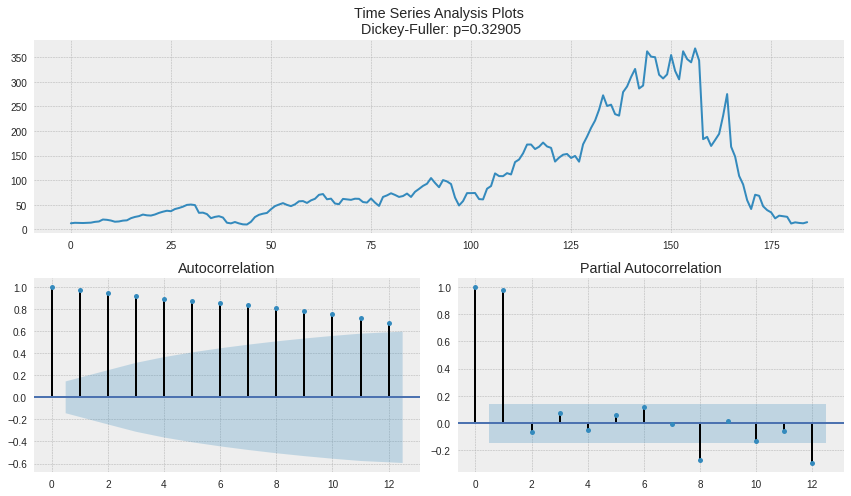

In [484]:
# plot to check stationarity
tsplot(df['Close'], lags=12)

#### The autocorrelation function still has too many significant lags. To remove them, we'll  subtract the series from itself with lag 1

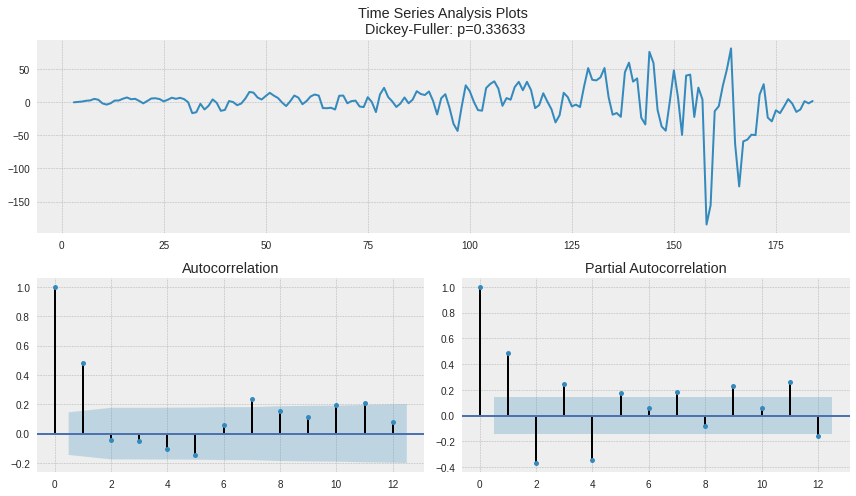

In [485]:
# differnce transform
diff = df['Close'] - df['Close'].shift(2)
tsplot(diff[3:], lags=12)

ARIMA - Parameters

    p: Trend autoregression order 
    d: Trend difference order.
    q: Trend moving average order.

- $p$ -  is most probably 2 since it is the last significant lag on the PACF, after which, most others are not significant. 
- $d$ equals 1 because we had first differences
- $q$ should be somewhere around 7 as well as seen on the ACF

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  180
Model:                 ARIMA(2, 1, 7)   Log Likelihood                -796.760
Method:                       css-mle   S.D. of innovations             19.459
Date:                Wed, 02 Feb 2022   AIC                           1615.521
Time:                        13:56:07   BIC                           1650.643
Sample:                             1   HQIC                          1629.761
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0692      0.053     -1.312      0.191      -0.173       0.034
ar.L1.D.Close     0.0495      0.057      0.862      0.390      -0.063       0.162
ar.L2.D.Close    -0.8507      0.049    -

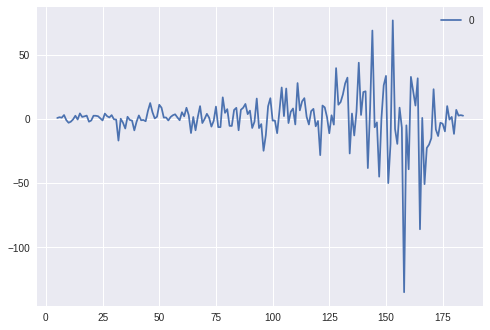

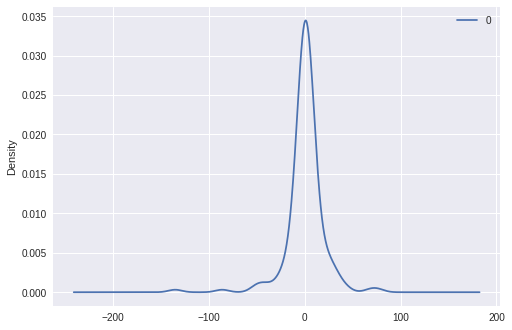

                0
count  180.000000
mean     0.699858
std     19.772919
min   -134.973398
25%     -3.872632
50%      1.353964
75%      7.002421
max     76.628446


In [486]:
# fit model
model = ARIMA(diff[4:], order=(2,1,7))
model = model.fit()

# summary of fit model
print(model.summary())

# line plot of residuals
residuals = pd.DataFrame(model.resid)
residuals.plot()
plt.show()

# density plot of residuals
residuals.plot(kind='kde')
plt.show()

# summary stats of residuals
print(residuals.describe())

In [487]:
# create series
diff = pd.Series(data=diff[5:])
diff1 = [0]*5
for i in diff:
  diff1.append(i*(-1)) 
diff1 = pd.Series(data=diff1)
diff1 = diff1[5:]

In [488]:
# plot MAPE of ARIMA
def plotARIMA(series, model, n_steps, d=1):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted ARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    # data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on d steps from the beginning
    error = mean_absolute_percentage_error(diff1[d:], data['arima_model'][d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.plot(diff1, label="actual")
    plt.legend()
    plt.grid(True);

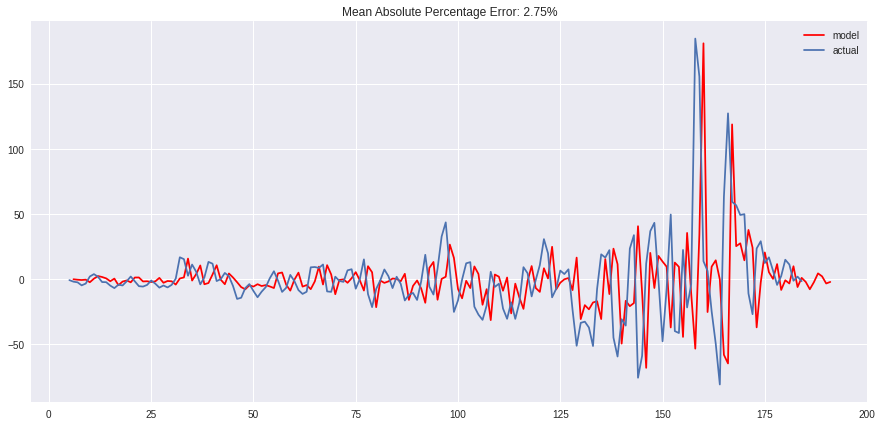

In [489]:
# model predictions vs actual
plotARIMA(diff1, model, 6)

## <b> Prophet Implementation 

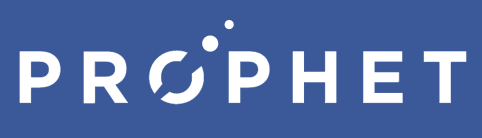

In [490]:
# set data to train and test
dfp = df[['Date','Close']][175:]
split_date = '2020-05-01'
df_train = dfp.loc[dfp['Date'] <= split_date].copy()
df_test = dfp.loc[dfp['Date'] > split_date].copy()

In [491]:
# rename columns appropriately
df_train = df_train.rename(columns={'Date':'ds','Close':'y'})
df_test = df_test.rename(columns={'Date':'ds','Close':'y'})

# select appropriate columns
df_test = df_test.drop(columns=['y'], axis=1)
df_test.reset_index(inplace=True)
df_test.drop(columns=['index'], axis=1, inplace=True)

In [492]:
# Setup and fit the model
m = Prophet()
m.fit(df_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 2.


In [493]:
# predicted closing prices
forecast = m.predict(df_test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-06-01,23.611288,18.873576,28.140377
1,2020-07-01,21.905547,17.149419,26.658300
2,2020-08-01,20.142949,14.893005,25.053254
3,2020-09-01,18.380351,13.489801,23.365973
4,2020-10-01,16.674611,11.839260,21.995898
5,2020-11-01,14.912013,10.107880,19.944177


In [494]:
# actual closing prices
df[179:][['Date','Close']]

,Date,Close
179,2020-06-01,25.60
180,2020-07-01,11.95
181,2020-08-01,14.37
182,2020-09-01,13.15
183,2020-10-01,12.42
184,2020-11-01,14.67


In [495]:
y_test = df[179:]['Close']
p_y_pred = forecast['yhat']

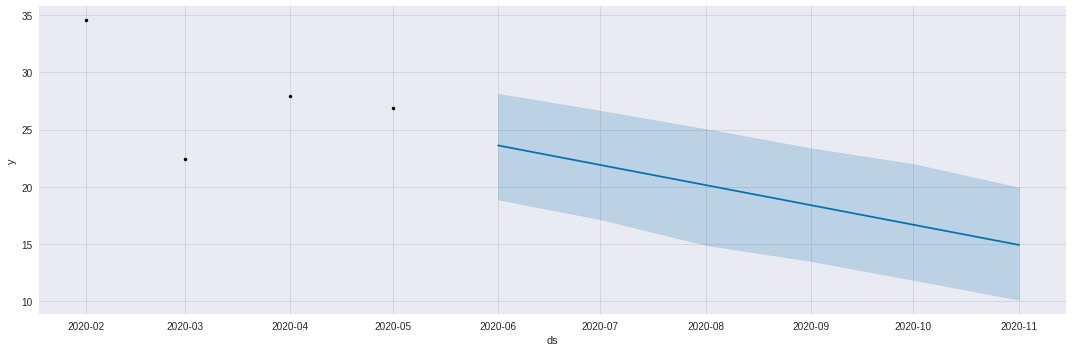

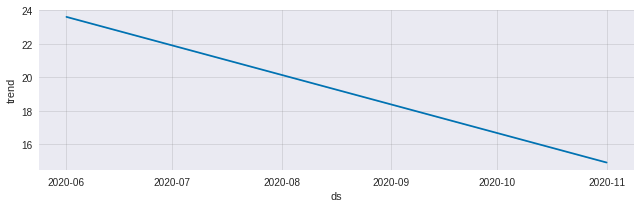

In [496]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = m.plot(forecast,
                 ax=ax)
plt.show()

# Plot the components of the model
fig = m.plot_components(forecast)

In [497]:
# evaluate predictions
p_mae = round(mean_absolute_error(y_test, p_y_pred),2)
print('mean absolute error: {}\n'.format(p_mae))
p_mse = round(mean_squared_error(y_test, p_y_pred),2)
print('mean squared error: {}\n'.format(p_mse))
p_rmse = round(np.sqrt(p_mse),2)
print('root mean squared error: {}\n'.format(p_rmse))
p_r2 = round(r2_score(y_test, p_y_pred),2)
print('r2_score: {}\n'.format(p_r2))
p_mape = round(mean_absolute_percentage_error(p_y_pred, y_test),2)
print('mean absolute percentage error: {}\n\n\n'.format(e_mape))

mean absolute error: 4.57

mean squared error: 30.32

root mean squared error: 5.51

r2_score: -0.38

mean absolute percentage error: 0.16





### <b> Conclusion

  *  We started with data inspection, viewed the data distribution, checked for correlation and used averaged features to remove correlation.  
  * A simple linear regression model was built and it was evaluated using accuracy, mean squared error, root mean squared error, r2_score and mean absolute percentage error.
  * Additional features were engineered by taking lags and reduced the effect of multi collinearity using regularization techniques such as ridge, lasso and elastic net regression.   
  * Regression models namely random forest regressor, xgboost regressor and support vector regressor were built.
  * The time component was brought in and used averaging techniques like moving average, exponentially weighted moving average and double exponentially weighted moving average to do time-series analysis.
  * Presence of non stationarity was detected, made it stationary by taking lags and difference transformation and built an ARIMA model.
  * Prophet model from facebook was implemented and predictions were made from it. 







